In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import json
import copy
import traceback

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
from log_parser import process_file


### parameters

In [4]:
# _fname = "../replays/local.log"
# _fname = "../replays/log12-multi.log"
_fname = "../replays/log13.log"
# _fname = "../replays/selftrade-rev.log"
_time_step = 100
_max_time = 200000
_num_close_turns = 30
_symbols = ["BANANAS", "PEARLS"]
_products = ["BANANAS", "PEARLS"]

print("_fname", _fname)


_fname ../replays/log13.log


### pre processing

In [5]:
# load data from file

obj = process_file(_fname)
raw_df = pd.DataFrame(obj)

listings = pd.DataFrame(raw_df["listings"][0])
# products = set(listings.T["product"])
raw_df = raw_df.drop("listings", axis=1)
raw_df = raw_df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_df["time"])
print("num missing_times", len(missing_times))
print("missing_times", missing_times)


Reading from input file ../replays/log13.log
num missing_times 3
missing_times {86200, 122300, 120800}


In [6]:
# add turns (vs time)

all_times = raw_df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
raw_df["turn"] = raw_df["time"].map(time2turn_map)

raw_df.index = raw_df["turn"]

In [7]:
book_data = []
book_cols = []

cmp = lambda k : tuple([int(k[0]), int(k[1])])

for sym in _symbols:
    ### buys
    col = raw_df["book"].apply(lambda x: x[sym])
    # convert dicts into int -> int
    col = col.apply(lambda x : [(int(k), v) for k, v in x["buy_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=True))
    col = col.apply(lambda x : x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_buy"]
    
    
    ### sells
    col = raw_df["book"].apply(lambda x: x[sym])
    col = col.apply(lambda x : [(int(k), v) for k, v in x["sell_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=False))
    col = col.apply(lambda x: x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_sell"]
    
    
book_tops = pd.concat(book_data, axis=1)
book_tops.columns = book_cols

# all book tops
for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    
    print("missing mids", sym, list(book_tops.index[book_tops[f"{sym}_mid"].isna()]))
    
    book_tops[f"{sym}_mid"] = book_tops[f"{sym}_mid"].bfill()
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = raw_df["time"]



missing mids BANANAS []
missing mids PEARLS []


In [8]:
num_data_dropna = len(book_tops.dropna())
num_data = len(book_tops)

print(f"Orig count: {num_data}")
print(f"Remaining count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 1997
Remaining count: 1997
nan count: 0


In [9]:
def report_issue_and_continue(condition, fail_msg):
    try:
        assert condition
    except:
        traceback.print_exc()
        display(fail_msg)

In [10]:
def flatten_trades(df, col, is_me):
    # get market trades

    data = []
    for index, row  in df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_buy"] = df["buyer"] == "SUBMISSION"
    df["my_sell"] = df["seller"] == "SUBMISSION"
    df["my_quantity"] = df["quantity"] * (df["my_buy"].astype(int) - df["my_sell"].astype(int))
    df["self_trade"] = df["my_buy"] & df["my_sell"]
    
    # report self trades
    self_trades = df[df["self_trade"]]
    report_issue_and_continue( len(self_trades) == 0, self_trades)
    
    return df

In [11]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    raw_df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    raw_df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")

market_trades = market_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])
my_trades = my_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])


### old filter methods
# # filter market trades (only keep those where order_time = fill_time)
# market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# # filter my_trades (only keep those where fill_time = order_time + 100)
# my_trades = my_trades[my_trades["time"] <= my_trades["order_time"] + _time_step]
### end of old filter methods

trade_df = pd.concat([market_trades, my_trades])
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)
# trade_df = trade_df.drop(["order_time", "buyer", "seller"], axis=1)

my_trades = trade_df[trade_df["is_me"]]
market_trades = trade_df[~trade_df["is_me"]]


In [12]:
for sym in _symbols:
    print(sym)
    
    my_sym_trades = my_trades[my_trades["symbol"] == sym]
    my_volume = my_sym_trades["quantity"].abs().sum()
    market_sym_trades = market_trades[market_trades["symbol"] == sym]
    market_volume = market_sym_trades["quantity"].abs().sum()
    
    my_vol_perc = my_volume / (my_volume + market_volume) * 100
    
    print("[THEM]\t count:", len(market_sym_trades), "\tvolume:", market_volume)
    print("[MY]\t count:", len(my_sym_trades), "\tvolume:", my_volume)
    print(f"[MY]\t vol%: {round(my_vol_perc, 2)}%")

BANANAS
[THEM]	 count: 358 	volume: 721
[MY]	 count: 335 	volume: 968
[MY]	 vol%: 57.31%
PEARLS
[THEM]	 count: 278 	volume: 471
[MY]	 count: 350 	volume: 552
[MY]	 vol%: 53.96%


In [13]:
# get my_positions
my_positions = pd.DataFrame(list(raw_df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = raw_df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
fixed_pos_data = []
pos_data = []
cur_positions = { prod: 0 for prod in _products }
cur_positions["cash"] = 0
fixed_positions = copy.deepcopy(cur_positions)

cur_time = turn2time_map[0]

def record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data):
    global my_positions
    
    # copy orig pos
    pos_data += [copy.deepcopy(cur_positions)]
    
    # fix positions if necessary
    cur_turn = time2turn_map[cur_time]
        
    # init fixed_positions for this turn
    for prod in _products:
        diff = my_positions[prod][cur_turn] - fixed_positions[prod]
        price = book_tops[f"{prod}_mid"][cur_turn]
        
        if diff != 0:
            print(f"[Fixed trade] Turn: {cur_turn}, time: {cur_time}, {prod} {diff} @ {price}")
            
        fixed_positions[prod] += diff
        fixed_positions["cash"] += -1 * diff * price

    # copy fixed pos
    fixed_pos_data += [copy.deepcopy(fixed_positions)]
    
    
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
        cur_time = turn2time_map[len(pos_data)]
        
    prod = listings[row["symbol"]]["product"]
    # update cur
    cur_positions["cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[prod] += row["my_quantity"]
    
    # update fixed
    fixed_positions["cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[prod] += row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)
    cur_time = turn2time_map[len(pos_data)]

record_pos_data(cur_positions, fixed_positions, cur_time, pos_data, fixed_pos_data)



# pos_df contains calculated position data (based on my_trades)
pos_df = pd.DataFrame(pos_data).sort_index(axis=1)

# add to my_positions
my_positions["cash"] = pos_df["cash"]
my_positions = my_positions.sort_index(axis=1)


try:
    for prod in ["cash", *_products]:
        bad_inds = my_positions.index[my_positions[prod] != pos_df[prod]]
        if len(bad_inds) > 0:
            print("true pos")
            display(my_positions.loc[bad_inds])
            print("calculated pos")
            display(pos_df.loc[bad_inds])
            assert False, f"Failed check for product: `{prod}`"
except AssertionError:
    traceback.print_exc()
    
    print("Using fixed_pos_df['cash']")
    fixed_pos_df = pd.DataFrame(fixed_pos_data).sort_index(axis=1)
    my_positions["cash"] = fixed_pos_df["cash"]

[Fixed trade] Turn: 1480, time: 148300, PEARLS -2.0 @ 10003.0
true pos


,BANANAS,PEARLS,cash,time,turn
1480,-19.0,-4.0,114518.0,148300,1480
1481,-20.0,-4.0,119425.0,148400,1481
1482,-20.0,-4.0,119425.0,148500,1482
1483,-20.0,-4.0,119425.0,148600,1483
1484,-20.0,-4.0,119425.0,148700,1484
...,...,...,...,...,...
1992,0.0,0.0,-18016.0,199500,1992
1993,0.0,0.0,-18016.0,199600,1993
1994,0.0,0.0,-18016.0,199700,1994
1995,0.0,0.0,-18016.0,199800,1995


calculated pos


,BANANAS,PEARLS,cash
1480,-19,-2,114518.0
1481,-20,-2,119425.0
1482,-20,-2,119425.0
1483,-20,-2,119425.0
1484,-20,-2,119425.0
...,...,...,...
1992,0,2,-18016.0
1993,0,2,-18016.0
1994,0,2,-18016.0
1995,0,2,-18016.0


Using fixed_pos_df['cash']


Traceback (most recent call last):
  File "/var/folders/fv/6rc0c0r11hn6xpyhsr9z6rrc0000gn/T/ipykernel_62051/1603851576.py", line 85, in <module>
    assert False, f"Failed check for product: `{prod}`"
AssertionError: Failed check for product: `PEARLS`


### Data analysis/vis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

### todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [14]:
# estimate fairs
mid_cols = [col for col in book_tops.columns if "_mid" in col]
fairs = book_tops[["time", *mid_cols]]
fairs.columns = fairs.columns.str.strip('_mid')

fairs

,time,BANANAS,PEARLS
turn,,,
0,0,4896.0,10001.5
1,100,4894.0,9999.0
2,200,4895.5,10000.0
3,300,4896.0,9997.0
4,400,4896.5,10001.0
...,...,...,...
1992,199500,4908.5,9997.0
1993,199600,4908.5,10000.0
1994,199700,4908.0,10003.0


In [15]:
# estimate pnl
pnls = my_positions["cash"]

for prod in _products:
    pnls = pnls + my_positions[prod] * fairs[prod]
    
my_positions["pnl"] = pnls

In [137]:
# plot trades
def plot_trades_and_book(
        sym, 
        trade_df, 
        book_df, 
        time_lb=float("-inf"), 
        time_ub=float("inf"), 
        span=21,
        show_mid=False,
        ):
    
    trade_df = trade_df[(time_lb <= trade_df["time"]) & (trade_df["time"] <= time_ub)]
    book_df = book_df[(time_lb <= book_df["time"]) & (book_df["time"] <= time_ub)]
    
    # filter for this symbol only
    plt_df = trade_df
    plt_df = plt_df[plt_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]
    
    
    
    def plot_trades(ax):
        ax.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
        ax.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
        ax.scatter(their_trades["time"], their_trades["price"], c="orange", s=5)
    
    
    book_df = book_df
    
    bids = book_df[f"{sym}_best_buy"]
    asks = book_df[f"{sym}_best_sell"]
    mids = book_df[f"{sym}_mid"]
    smooth_bids = bids.ewm(span=span).mean()
    smooth_asks = asks.ewm(span=span).mean()
    smooth_mids = mids.ewm(span=span).mean()
    
#     plt.figsize(5, 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    times = book_df["time"]
    
    # plot book
    ax = axes[0]
    ax.plot(times, bids, c="green", alpha=0.5, linewidth=0.5)
    ax.plot(times, asks, c="red", alpha=0.5, linewidth=0.5)
    if show_mid:
        ax.plot(times, mids, c="black", alpha=0.25, linewidth=0.5)
    plot_trades(ax)
    ax.set_title(f"Trades and book: {sym}")
    
    ax = axes[1]
    ax.plot(times, smooth_bids, c="green", alpha=0.5, linewidth=0.5)
    ax.plot(times, smooth_asks, c="red", alpha=0.5, linewidth=0.5)
    if show_mid:
        ax.plot(times, smooth_mids, c="black", alpha=0.5, linewidth=0.5)
    ax.set_title(f"(smooth) Trades and book: {sym}")
    plot_trades(ax)

    plt.show()
    

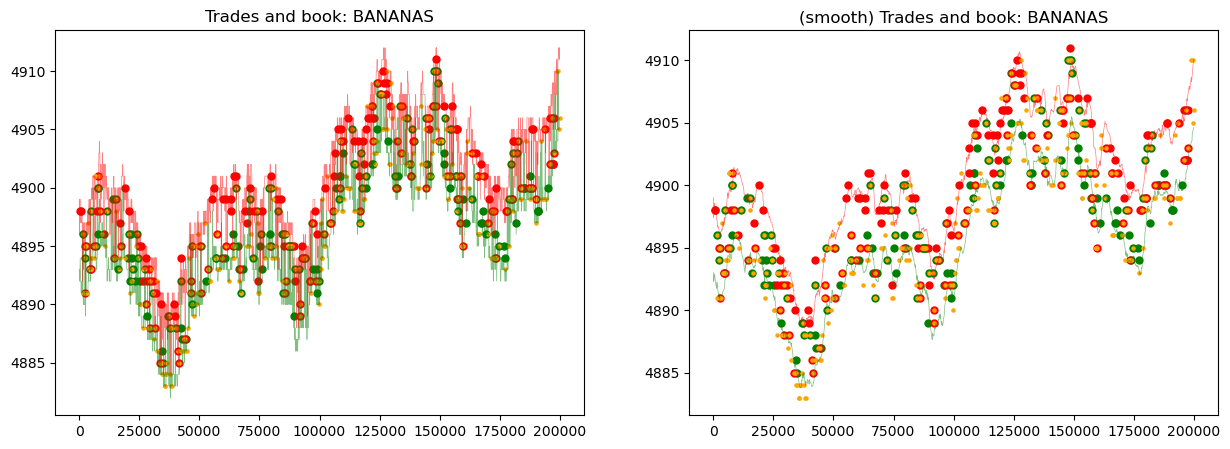

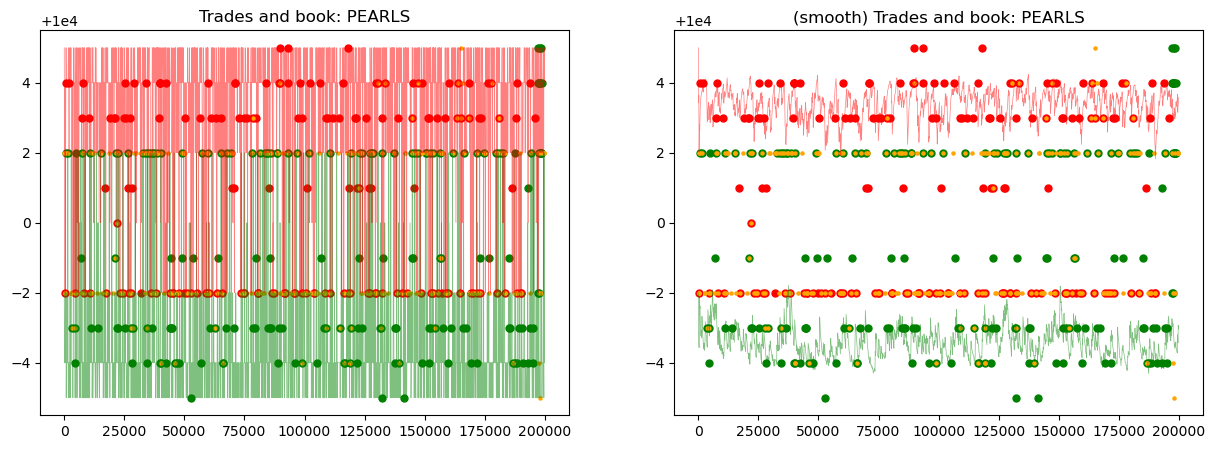

In [138]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=trade_df, 
    book_df=book_tops, 
#     time_lb=0, 
#     time_ub=50000, 
    span=21
)
plot_trades_and_book(
    sym="PEARLS", 
    trade_df=trade_df, 
    book_df=book_tops, 
#     time_lb=0, 
#     time_ub=50000, 
    span=21
)


Text(0.5, 1.0, 'PNL')

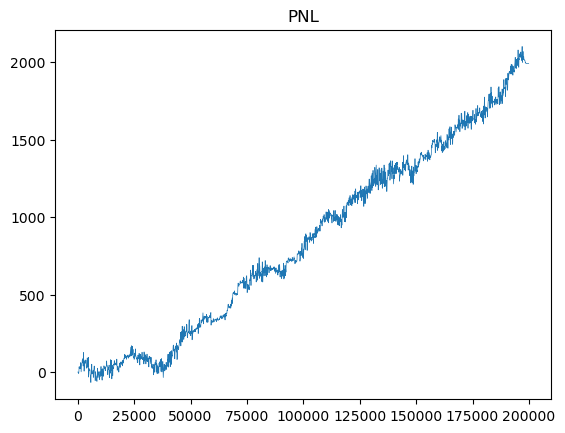

In [139]:
# pnl
plt.plot(my_positions["time"], my_positions["pnl"], linewidth=0.5)
plt.title("PNL")

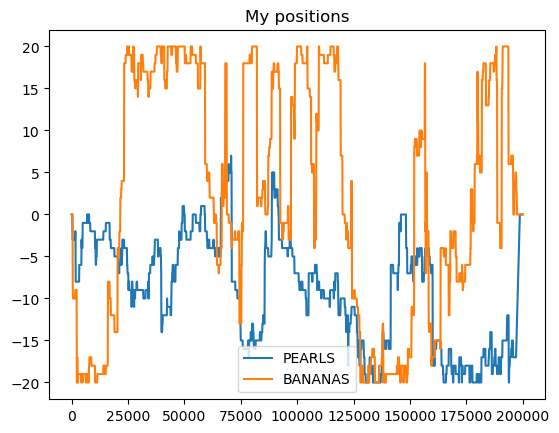

In [140]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"], label="PEARLS")
plt.plot(my_positions["time"], my_positions["BANANAS"], label="BANANAS")
plt.title("My positions")
plt.legend()
plt.show()

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,1996.0,1.000001,0.000339,0.998777,0.999796,1.0,1.000204,1.001227
PEARLS_mid,1996.0,1.000000,0.000212,0.999300,0.999900,1.0,1.000100,1.000700


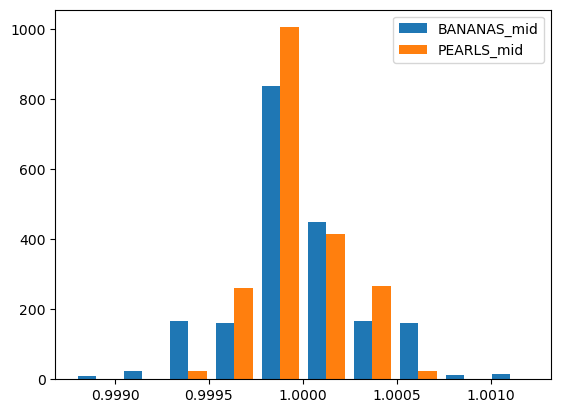

In [141]:
# distribution of price movements (pct change)
mids = ["BANANAS_mid", "PEARLS_mid"]

col = book_tops[mids]
diffs = (col.shift(-1) / col).dropna()
plt.hist(diffs, label=mids)
plt.legend()
diffs.describe().T


,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,1996.0,0.006513,1.658489,-6.0,-1.0,0.0,1.0,6.0
PEARLS_mid,1996.0,0.000000,2.122324,-7.0,-1.0,0.0,1.0,7.0


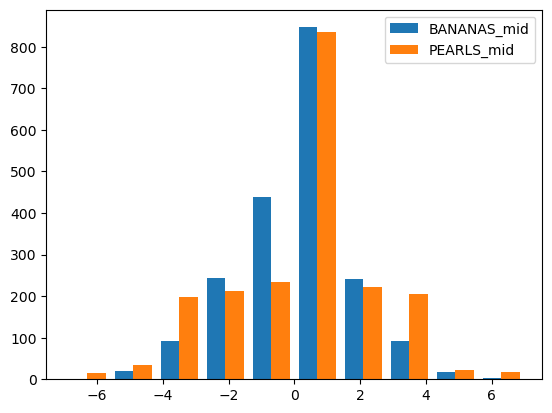

In [142]:
# distribution of price movements (actual #)
mids = ["BANANAS_mid", "PEARLS_mid"]

col = book_tops[mids]
diffs = (col.shift(-1) - col).dropna()
plt.hist(diffs, label=mids)
plt.legend()
diffs.describe().T


In [143]:
trade_df.groupby("time")[["quantity"]].sum().describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,708.0,3.830508,3.941162,1.0,1.0,1.0,1.0,2.0,4.0,9.0,19.0,28.0


In [144]:
# spread summary stats

sym = "BANANAS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1997.0,5.278918,1.892878,1.0,5.0,6.0,7.0,7.0


In [145]:
# spread summary stats

sym = "PEARLS"
spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
spreads.describe().T

,count,mean,std,min,25%,50%,75%,max
0,1997.0,6.818728,2.466446,2.0,6.0,8.0,8.0,10.0


In [146]:
# find performance of trades after 1 tick, 10 ticks, 100 ticks
# returns only my trades for the specified symbol
def calc_rtns(trade_df, sym, waits):
    global fairs
    
    df = trade_df
    df = df[df["symbol"] == sym]
    df = df[df["is_me"]]
    
    # exclude trades during "closing time"
    cutoff_time = _max_time - _num_close_turns * _time_step
    df = df[df["time"] < cutoff_time]

    for wait in waits:
        suffix = f"_{wait}"

        # get shifted fairs
        fairs_shift = fairs.set_index("time").shift(-1 * wait).ffill().bfill().add_suffix(suffix)
        fairs_shift = fairs_shift.reset_index()

        df = pd.merge(df, fairs_shift)

    for wait in waits:
        df[f"rtn_{wait}"] = (df[f"{sym}_{wait}"] - df["price"]) * np.sign(df["my_quantity"])

    return df



total prof 929.5


,count,mean,std,min,25%,50%,75%,max
rtn_-1,330.0,1.434848,0.774497,0.0,0.500,1.5,2.0,3.0
rtn_0,330.0,0.381818,2.419143,-5.5,-1.500,1.0,2.5,5.5
rtn_1,330.0,0.369697,2.458097,-5.5,-1.875,0.5,2.5,6.5
rtn_3,330.0,0.566667,2.462505,-5.5,-1.500,1.0,2.5,7.5
rtn_10,330.0,0.483333,2.788741,-7.5,-1.500,0.5,2.5,7.5
rtn_30,330.0,0.536364,3.471142,-10.5,-2.000,0.5,3.0,9.0
rtn_100,330.0,0.536364,4.959889,-12.0,-3.000,0.5,4.5,13.0


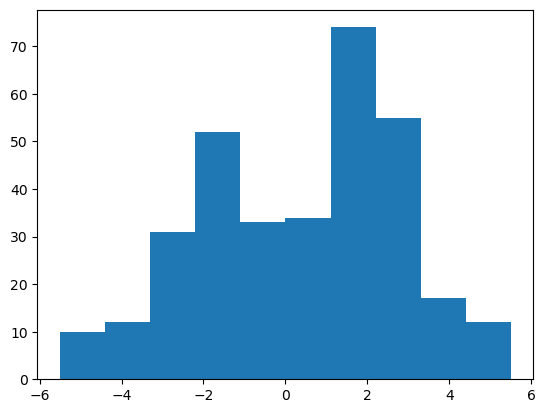

In [147]:
# summary stats for trades vs rtns

sym = "BANANAS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

In [148]:
def blur(df, mu=0, std=0.1):
    noise = np.random.normal(loc=mu, scale=std, size=df.shape)
    return df + noise

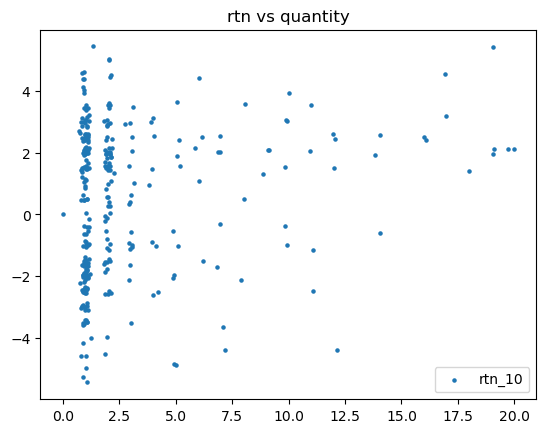

In [149]:
plt.scatter(blur(df["quantity"], std=0.1), blur(df["rtn_0"], std=0.1), s=5, label="rtn_10")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



In [150]:
# print out large trades

sizes = df.groupby("time")[["quantity"]].sum()
big_days = sizes[sizes["quantity"] >= 15]
df[df["time"].isin(big_days.index)]

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_3,rtn_10,rtn_30,rtn_100,rtn_0_total
102,SUBMISSION,4893.0,16,,BANANAS,68000,68100,681,True,True,...,4898.5,10003.0,2.5,2.5,0.5,2.0,3.5,2.5,5.5,40.0
103,,4898.0,18,SUBMISSION,BANANAS,68700,68800,688,True,False,...,4900.5,10003.0,1.5,1.5,-0.0,1.5,-0.0,-0.0,-2.5,27.0
115,SUBMISSION,4893.0,20,,BANANAS,76000,76100,761,True,True,...,4893.0,10000.0,1.5,2.0,2.5,3.0,4.0,1.5,0.0,40.0
122,,4899.0,19,SUBMISSION,BANANAS,82100,82200,822,True,False,...,4891.5,10003.5,2.0,2.0,2.0,-0.0,2.0,5.5,7.5,38.0
144,,4895.0,17,SUBMISSION,BANANAS,92400,92500,924,True,False,...,4898.5,10000.0,0.5,4.5,3.5,3.0,4.0,2.5,-3.5,76.5
145,SUBMISSION,4894.0,1,,BANANAS,92400,92500,924,True,True,...,4898.5,10000.0,0.5,-3.5,-2.5,-2.0,-3.0,-1.5,4.5,-3.5
153,SUBMISSION,4893.0,17,,BANANAS,97200,97300,972,True,True,...,4903.5,9999.0,1.5,3.0,2.5,2.5,1.5,2.0,10.5,51.0
191,SUBMISSION,4901.0,1,,BANANAS,119200,119300,1192,True,True,...,4906.5,9997.0,2.0,2.5,2.5,2.5,1.0,4.0,5.5,2.5
192,,4905.0,12,SUBMISSION,BANANAS,119200,119300,1192,True,False,...,4906.5,9997.0,2.0,1.5,1.5,1.5,3.0,-0.0,-1.5,18.0
193,SUBMISSION,4900.0,2,,BANANAS,119200,119300,1192,True,True,...,4906.5,9997.0,3.0,3.5,3.5,3.5,2.0,5.0,6.5,7.0


In [151]:
losers = df[(df["rtn_10"] < 0)]
winners = df[df["rtn_10"] > 0]

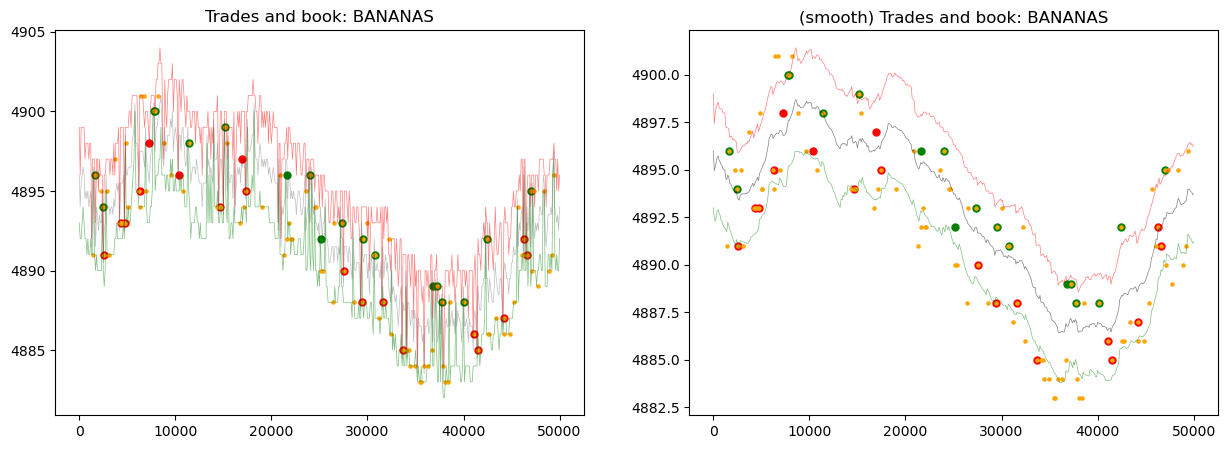

In [153]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=50000, 
    span=21,
    show_mid=True,
)


total prof 683.0


,count,mean,std,min,25%,50%,75%,max
rtn_-1,333.0,2.100601,1.038969,-2.0,1.0,2.0,3.0,4.0
rtn_0,333.0,0.876877,3.073376,-5.5,-2.0,1.0,3.0,7.5
rtn_1,333.0,0.989489,3.039506,-5.5,-2.0,1.0,3.0,7.5
rtn_3,333.0,0.936937,2.930251,-5.5,-2.0,1.0,3.0,7.5
rtn_10,333.0,0.917417,3.085859,-5.5,-2.0,1.0,3.0,7.5
rtn_30,333.0,0.848348,3.034238,-5.5,-2.0,1.0,3.0,7.5
rtn_100,333.0,0.912913,2.986150,-5.5,-2.0,1.0,3.0,7.5


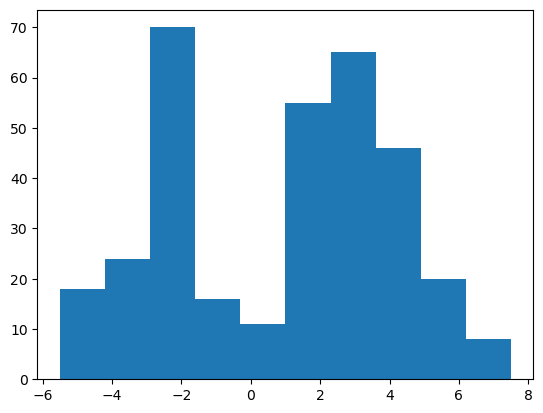

In [154]:
### summary stats for trades vs rtns

sym = "PEARLS"
waits=[-1, 0, 1, 3, 10, 30, 100]

df = calc_rtns(trade_df, sym=sym, waits=waits)
plt.hist(df["rtn_0"])

df["rtn_0_total"] = df["rtn_0"] * df["quantity"]

print("total prof", df["rtn_0_total"].sum())

display(df[[f"rtn_{wait}" for wait in waits]].describe().T)

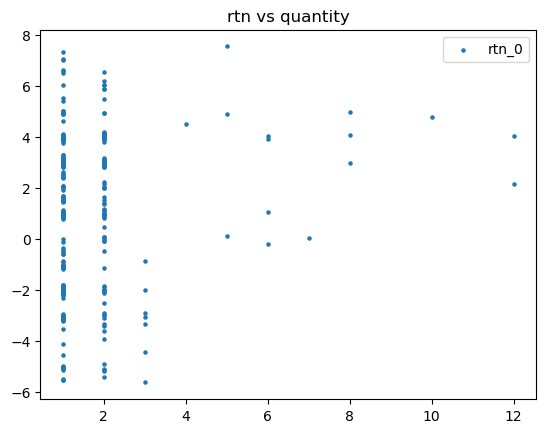

In [36]:
plt.scatter(blur(df["quantity"], std=0.0), blur(df["rtn_0"], std=0.1), s=5, label="rtn_0")
# plt.scatter(blur(df["quantity"]), blur(df["rtn_100"]), s=5, label="rtn_100")
plt.title("rtn vs quantity")
plt.legend()
plt.show()



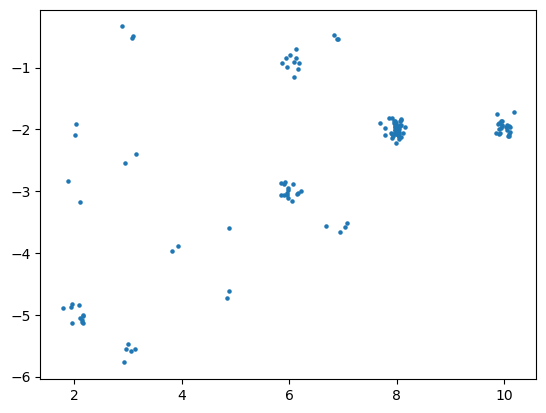

In [37]:
losers = df[(df["rtn_0"] < 0)]
winners = df[df["rtn_0"] > 0]

df = pd.merge(losers, book_tops[["PEARLS_spread", "time"]].shift(1), on="time")
plt.scatter(blur(df["PEARLS_spread"]), blur(df["rtn_0"]), s=5)

In [38]:
losers.describe().T

,count,mean,std,min,25%,50%,75%,max
price,128.0,9999.898438,1.999369,9997.0,9998.000,9998.00,10002.00,10003.0
quantity,128.0,1.296875,0.566233,1.0,1.000,1.00,1.00,3.0
order_time,128.0,101112.500000,56662.541613,300.0,53950.000,102700.00,152175.00,195100.0
time,128.0,101212.500000,56662.541613,400.0,54050.000,102800.00,152275.00,195200.0
turn,128.0,1010.695312,565.361783,4.0,540.500,1027.00,1519.75,1949.0
my_quantity,128.0,-0.109375,1.415518,-3.0,-1.000,-1.00,1.00,3.0
BANANAS_-1,128.0,4898.273438,5.623299,4885.5,4894.875,4898.25,4902.50,4910.5
PEARLS_-1,128.0,9999.835938,3.096295,9996.5,9997.000,9998.75,10003.00,10003.5
BANANAS_0,128.0,4898.261719,5.570226,4886.0,4894.000,4898.00,4902.50,4910.0
PEARLS_0,128.0,10000.132812,1.554121,9996.5,10000.000,10000.00,10001.00,10003.5


In [39]:
losers[["price", "my_quantity", "symbol", "time", "PEARLS_-1", "PEARLS_0", "rtn_-1", "rtn_0"]]

,price,my_quantity,symbol,time,PEARLS_-1,PEARLS_0,rtn_-1,rtn_0
0,9998.0,-3,PEARLS,400,9997.0,10001.0,1.0,-3.0
1,10002.0,1,PEARLS,600,10003.0,9999.0,1.0,-3.0
3,10002.0,1,PEARLS,1600,10003.0,10000.0,1.0,-2.0
8,9998.0,-1,PEARLS,4500,9997.0,10000.0,1.0,-2.0
9,10002.0,3,PEARLS,4900,10003.0,9996.5,1.0,-5.5
...,...,...,...,...,...,...,...,...
321,9998.0,-1,PEARLS,189900,9996.5,9999.0,1.5,-1.0
322,9998.0,-1,PEARLS,190100,9997.0,9998.5,1.0,-0.5
325,10001.0,2,PEARLS,193000,10002.5,9997.5,1.5,-3.5
329,10002.0,1,PEARLS,194300,10003.0,10000.0,1.0,-2.0


(array([ 3.,  7.,  4., 42., 27., 21.,  4.,  3.,  7., 10.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

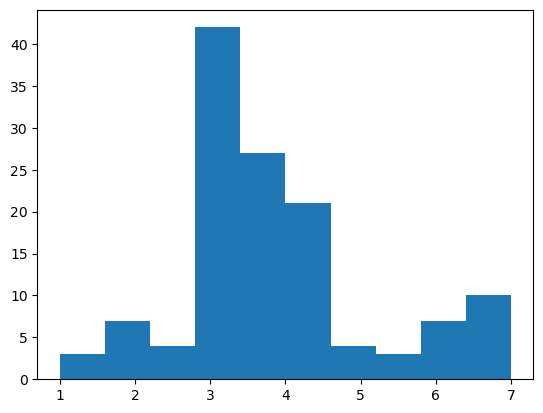

In [40]:
loser_diffs = (abs(losers["PEARLS_-1"] - losers["PEARLS_0"]))

plt.hist(loser_diffs)

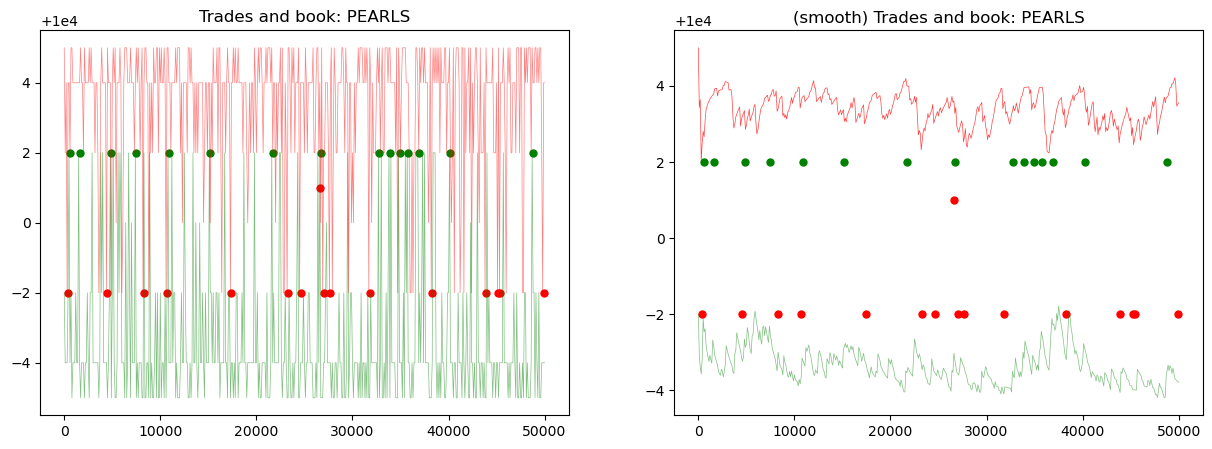

In [41]:
plot_trades_and_book(
    sym="BANANAS", 
    trade_df=pd.concat([losers, market_trades], axis=0), 
    book_df=book_tops, 
    time_lb=0, 
    time_ub=10000, 
    span=21
)


In [42]:
losers

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,...,BANANAS_100,PEARLS_100,rtn_-1,rtn_0,rtn_1,rtn_3,rtn_10,rtn_30,rtn_100,rtn_0_total
0,,9998.0,3,SUBMISSION,PEARLS,300,400,4,True,False,...,4898.5,10000.0,1.0,-3.0,-5.0,-3.5,-2.0,-2.0,-2.0,-9.0
1,SUBMISSION,10002.0,1,,PEARLS,500,600,6,True,True,...,4897.5,9996.5,1.0,-3.0,-0.5,-2.0,-2.0,-5.5,-5.5,-3.0
3,SUBMISSION,10002.0,1,,PEARLS,1500,1600,16,True,True,...,4895.5,10000.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
8,,9998.0,1,SUBMISSION,PEARLS,4400,4500,45,True,False,...,4893.5,9998.0,1.0,-2.0,-2.0,-5.0,-2.0,-2.0,-0.0,-2.0
9,SUBMISSION,10002.0,3,,PEARLS,4800,4900,49,True,True,...,4895.5,9999.0,1.0,-5.5,-1.0,-2.0,0.0,-3.0,-3.0,-16.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,,9998.0,1,SUBMISSION,PEARLS,189800,189900,1896,True,False,...,4909.0,10001.5,1.5,-1.0,1.0,1.5,-0.5,-4.5,-3.5,-1.0
322,,9998.0,1,SUBMISSION,PEARLS,190000,190100,1898,True,False,...,4909.0,10001.5,1.0,-0.5,1.5,-3.0,-2.0,-2.0,-3.5,-0.5
325,SUBMISSION,10001.0,2,,PEARLS,192900,193000,1927,True,True,...,4909.0,10001.5,1.5,-3.5,-1.0,-2.0,-1.0,-1.0,0.5,-7.0
329,SUBMISSION,10002.0,1,,PEARLS,194200,194300,1940,True,True,...,4909.0,10001.5,1.0,-2.0,1.0,-2.0,-2.0,-1.0,-0.5,-2.0
